# GoogLeNet

### Imports

In [8]:
import os
import time
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from googlenet_model import GoogLeNet


import sys
sys.path.insert(0, '../helper_functions')

from eval import set_seed, compute_confusion_matrix, compute_accuracy
from plot import plot_training_loss, plot_accuracy, plot_confusion_matrix
from dataset_loader import get_dataloaders_cifar10, get_dataloaders_imagenet

### Initialize Setting

In [9]:
RANDOM_SEED = 1234
BATCH_SIZE = 128
NUM_EPOCHS = 20

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: ', DEVICE)
set_seed(RANDOM_SEED)

Device:  cuda:0


### Apply transforms to data

In [10]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ToTensor()
])

# train_loader, valid_loader, test_loader = get_dataloaders_imagenet(
#     batch_size=BATCH_SIZE,
#     train_transforms=test_transforms,
#     test_transforms=test_transforms,
#     num_workers=2
# )

train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=test_transforms,
    test_transforms=test_transforms,
    num_workers=2
)

train_mean, train_std = [], []

for i, image in enumerate(train_loader, 0):
    np_image = image[0].numpy()

    batch_mean = np.mean(np_image, axis=(0, 2, 3))
    batch_std= np.std(np_image, axis=(0, 2, 3))

    train_mean.append(batch_mean)
    train_std.append(batch_std)

train_mean = np.mean(train_mean, axis=0)
train_std = np.mean(train_std, axis=0)

# train_mean = [0.48050696, 0.4483643,  0.39774126]
# train_std  = [0.26106745, 0.25452408, 0.2638668]

print(f'Mean: {train_mean}')
print(f'Std: {train_std}')

Files already downloaded and verified
Mean: [0.49152106 0.48210174 0.44642982]
Std: [0.2410465  0.23764916 0.25611374]


In [11]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ToTensor()
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ToTensor()
])

# train_loader, valid_loader, test_loader = get_dataloaders_imagenet(
#     batch_size=BATCH_SIZE,
#     train_transforms=train_transforms,
#     test_transforms=test_transforms,
#     num_workers=2
# )

train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2
)


Files already downloaded and verified


In [12]:
def train_model(model, num_epochs, criterion,
                train_loader, valid_loader, test_loader,
                optimizer, device, use_auxiliary=True,
                logging_interval=50, scheduler=None):

    start_time = time.time()
    mini_batch_loss_list, train_acc_list, valid_acc_list = [], [], []

    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets  = targets.to(device)

            optimizer.zero_grad()

            if use_auxiliary:
                logits, aux1, aux2 = model(features)
                loss =       criterion(logits, targets) + \
                       0.3 * criterion(aux1, targets) + \
                       0.3 * criterion(aux2, targets)
            else:
                logits, _, _ = model(features)
                loss = criterion(logits, features)

            loss.backward()
            optimizer.step()

            mini_batch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d}'
                      f' | Batch {batch_idx:04d}/{len(train_loader):04d}'
                      f' | Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():
            train_accuracy = compute_accuracy(model, train_loader, device=device)
            valid_accuracy = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d}'
                  f' | Train: {train_accuracy:.2f}%'
                  f' | Validation: {valid_accuracy:.2f}%')

            train_acc_list.append(train_accuracy.item())
            valid_acc_list.append(valid_accuracy.item())

            elapsed_time = (time.time()-start_time)/60
            print(f'Time elapsed: {elapsed_time:.2f} min')

            scheduler.step(valid_acc_list[-1])

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy: {test_acc:.2f}%')

    return mini_batch_loss_list, train_acc_list, valid_acc_list

In [13]:
model = GoogLeNet(num_Classes=1000)

model = model.to(DEVICE)
print(f'Device: {DEVICE}')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

torch.cuda.empty_cache()
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    criterion=criterion,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=200,
    scheduler=scheduler)

Device: cuda:0
Epoch: 001/020 | Batch 0000/0351 | Loss: 12.2641
Epoch: 001/020 | Batch 0200/0351 | Loss: 2.4179
Epoch: 001/020 | Train: 51.10% | Validation: 51.50%
Time elapsed: 4.27 min
Epoch: 002/020 | Batch 0000/0351 | Loss: 2.0320
Epoch: 002/020 | Batch 0200/0351 | Loss: 1.8505
Epoch: 002/020 | Train: 69.99% | Validation: 68.09%
Time elapsed: 8.56 min
Epoch: 003/020 | Batch 0000/0351 | Loss: 1.5022
Epoch: 003/020 | Batch 0200/0351 | Loss: 1.3573
Epoch: 003/020 | Train: 71.57% | Validation: 69.47%
Time elapsed: 12.80 min
Epoch: 004/020 | Batch 0000/0351 | Loss: 0.9896
Epoch: 004/020 | Batch 0200/0351 | Loss: 1.2878
Epoch: 004/020 | Train: 81.06% | Validation: 77.60%
Time elapsed: 17.01 min
Epoch: 005/020 | Batch 0000/0351 | Loss: 0.7753
Epoch: 005/020 | Batch 0200/0351 | Loss: 0.6843
Epoch: 005/020 | Train: 85.20% | Validation: 79.19%
Time elapsed: 21.22 min
Epoch: 006/020 | Batch 0000/0351 | Loss: 0.6062
Epoch: 006/020 | Batch 0200/0351 | Loss: 1.0182
Epoch: 006/020 | Train: 81.91%

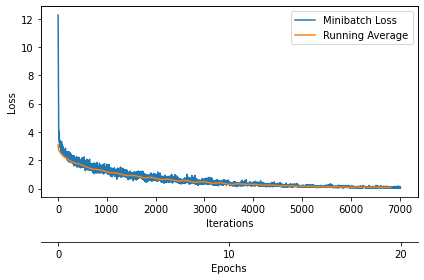

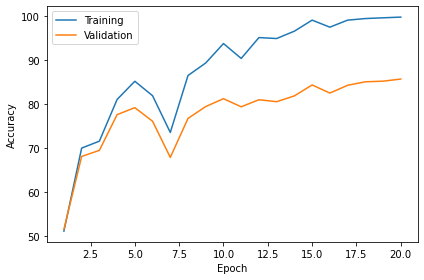

In [14]:
plot_training_loss(mini_batch_loss_list=minibatch_loss_list,
                   num_epoch=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   result_dir=None,
                   averaging_iteration=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

plt.show()

In [15]:
os.makedirs('../save_model', exist_ok=True)
torch.save(model.state_dict(), '../save_model/GoogLeNet.pt')